이번 주차 과제는 간단한 이미지 데이터를 활용해 크기가 큰 데이터의 차원 축소를 진행하고 데이터의 라벨에 따라 클러스터링을 진행하는 과제입니다.

###필요한 모듈을 가져오세요.

In [349]:
import torch
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import numpy as np
import seaborn as sns

랜덤 시드 고정

In [351]:
RandomSeed = 110

경고 문구 제거

In [350]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Image data 가져오기
https://www.kaggle.com/datasets/zalando-research/fashionmnist/data

###위 링크의 fashion mnist 데이터의 train dataset과 test dataset을 가져오세요.
(데이터의 용량이 크니 직접 다운로드 하지 말고 코드를 이용해 가져오도록 해보세요.)

In [352]:
# Fashion MNIST 데이터셋 로드
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

###데이터에 대한 정보들을 보여주세요.
(필수: 요약, 모양, 크기, 결측치 여부 등)

In [353]:
# 데이터셋 요약 정보
print("데이터셋 요약 정보:")
print(f"훈련 이미지 개수: {train_images.shape[0]}")
print(f"테스트 이미지 개수: {test_images.shape[0]}")
print(f"이미지 크기: {train_images.shape[1]}x{train_images.shape[2]}")
print(f"클래스 개수: {len(np.unique(train_labels))}")

# 데이터셋 모양
print("\n데이터셋 모양:")
print(f"훈련 이미지 모양: {train_images.shape}")
print(f"훈련 라벨 모양: {train_labels.shape}")
print(f"테스트 이미지 모양: {test_images.shape}")
print(f"테스트 라벨 모양: {test_labels.shape}")

# 데이터셋 크기
print("\n데이터셋 크기:")
print(f"훈련 이미지 크기: {train_images.size}")
print(f"훈련 라벨 크기: {train_labels.size}")
print(f"테스트 이미지 크기: {test_images.size}")
print(f"테스트 라벨 크기: {test_labels.size}")

# 결측치 여부 확인
print("\n결측치 여부 확인:")
print(f"훈련 이미지 결측치: {np.isnan(train_images).sum()}")
print(f"훈련 라벨 결측치: {np.isnan(train_labels).sum()}")
print(f"테스트 이미지 결측치: {np.isnan(test_images).sum()}")
print(f"테스트 라벨 결측치: {np.isnan(test_labels).sum()}")

데이터셋 요약 정보:
훈련 이미지 개수: 60000
테스트 이미지 개수: 10000
이미지 크기: 28x28
클래스 개수: 10

데이터셋 모양:
훈련 이미지 모양: (60000, 28, 28)
훈련 라벨 모양: (60000,)
테스트 이미지 모양: (10000, 28, 28)
테스트 라벨 모양: (10000,)

데이터셋 크기:
훈련 이미지 크기: 47040000
훈련 라벨 크기: 60000
테스트 이미지 크기: 7840000
테스트 라벨 크기: 10000

결측치 여부 확인:
훈련 이미지 결측치: 0
훈련 라벨 결측치: 0
테스트 이미지 결측치: 0
테스트 라벨 결측치: 0


### Data중 첫 번째 이미지를 보여주세요.

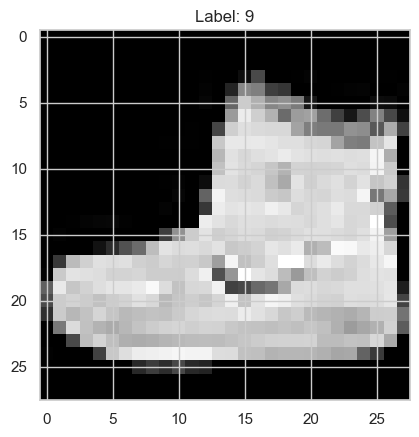

In [354]:
# 첫 번째 이미지 시각화
plt.imshow(train_images[0], cmap='gray')
plt.title(f"Label: {train_labels[0]}")
plt.show()

# 이미지 전처리

### 이미지 데이터를 머신러닝에 이용하기 편한 형태로 바꾸어 합니다.
(torch model 사용 - tensor 형태로 바꾸기 등)

In [355]:
# 필요한 라이브러리 임포트
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np

# 데이터 변환 정의 (텐서로 변환)
transform = transforms.Compose([
    transforms.Lambda(lambda x: torch.tensor(np.array(x), dtype=torch.float32)),  # 이미지를 텐서로 변환
])

# Fashion MNIST 데이터셋 로드
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# 데이터 로더 생성
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 데이터셋 및 데이터 로더 정보 출력
print(f"훈련 데이터셋 크기: {len(train_dataset)}")
print(f"테스트 데이터셋 크기: {len(test_dataset)}")

# 첫 번째 배치의 이미지와 라벨 확인
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(f"첫 번째 배치 이미지 크기: {images.shape}")
print(f"첫 번째 배치 라벨 크기: {labels.shape}")

# 첫 번째 이미지의 최소값과 최대값 확인
print(f"첫 번째 이미지의 최소값: {images[0].min()}")
print(f"첫 번째 이미지의 최대값: {images[0].max()}")

훈련 데이터셋 크기: 60000
테스트 데이터셋 크기: 10000
첫 번째 배치 이미지 크기: torch.Size([64, 28, 28])
첫 번째 배치 라벨 크기: torch.Size([64])
첫 번째 이미지의 최소값: 0.0
첫 번째 이미지의 최대값: 255.0


### 이미지 데이터는 픽셀 값이 0 - 255로 이루어져 있습니다. 이 값을 0 - 1까지의 값으로 normalize 해주세요.

In [356]:
# 데이터 변환 정의 (텐서로 변환 및 정규화)
transform = transforms.Compose([
    transforms.ToTensor(),  # 이미지를 텐서로 변환하고, 픽셀 값을 [0, 1] 범위로 정규화
])

# Fashion MNIST 데이터셋 로드
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# 데이터 로더 생성
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 데이터셋 및 데이터 로더 정보 출력
print(f"훈련 데이터셋 크기: {len(train_dataset)}")
print(f"테스트 데이터셋 크기: {len(test_dataset)}")

# 첫 번째 배치의 이미지와 라벨 확인
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(f"첫 번째 배치 이미지 크기: {images.shape}")
print(f"첫 번째 배치 라벨 크기: {labels.shape}")

# 첫 번째 이미지의 최소값과 최대값 확인
print(f"첫 번째 이미지의 최소값: {images[0].min()}")
print(f"첫 번째 이미지의 최대값: {images[0].max()}")

훈련 데이터셋 크기: 60000
테스트 데이터셋 크기: 10000
첫 번째 배치 이미지 크기: torch.Size([64, 1, 28, 28])
첫 번째 배치 라벨 크기: torch.Size([64])
첫 번째 이미지의 최소값: 0.0
첫 번째 이미지의 최대값: 1.0


### 추가적인 이미지 전처리를 진행해주세요.
(차원을 수정하는 것은 뒤의 문제에서 진행할 것이므로 여기에서 하지 마세요.)

In [357]:
# 데이터 변환 정의 (텐서로 변환, 정규화 및 데이터 증강)
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # 무작위로 좌우 반전
    transforms.RandomRotation(10),      # 무작위로 10도 이내 회전
    transforms.ToTensor(),              # 텐서로 변환 및 [0, 1] 범위로 정규화
])

# Fashion MNIST 데이터셋 로드
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# 데이터 로더 생성
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 데이터셋 및 데이터 로더 정보 출력
print(f"훈련 데이터셋 크기: {len(train_dataset)}")
print(f"테스트 데이터셋 크기: {len(test_dataset)}")

# 첫 번째 배치의 이미지와 라벨 확인
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(f"첫 번째 배치 이미지 크기: {images.shape}")
print(f"첫 번째 배치 라벨 크기: {labels.shape}")

# 첫 번째 이미지의 최소값과 최대값 확인
print(f"첫 번째 이미지의 최소값: {images[0].min()}")
print(f"첫 번째 이미지의 최대값: {images[0].max()}")

훈련 데이터셋 크기: 60000
테스트 데이터셋 크기: 10000
첫 번째 배치 이미지 크기: torch.Size([64, 1, 28, 28])
첫 번째 배치 라벨 크기: torch.Size([64])
첫 번째 이미지의 최소값: 0.0
첫 번째 이미지의 최대값: 1.0


# 차원 축소
차원 축소란 고차원 데이터를 효율적으로 처리하기 위한 기법입니다.
### 그 중 대표적인 PCA와 t-sne에 대한 내용을 비교하여 아래에 적어주세요.

### PCA (Principal Component Analysis)
#### 정의:   
PCA는 고차원 데이터를 저차원으로 변환하는 선형 차원 축소 기법으로  
데이터의 분산을 최대화하는 방향으로 주성분을 찾음   
#### 방법:   
공분산 행렬을 계산하고, 고유값 분해를 통해 주성분을 찾음   
이때 가장 큰 고유값에 해당하는 고유벡터가 주성분이 됨    
#### 특징:    
- 선형 변환을 사용    
- 데이터의 분산을 최대한 보존.     
- 계산이 비교적 빠르고 효율적  
- 주로 데이터의 구조를 이해하고 시각화하는 데 사용   
#### 단점:      
- 비선형 관계를 잘 포착하지 못함       
- 데이터의 분산이 큰 방향만을 고려하므로, 중요한 정보가 손실될 수 있음     

### t-SNE (t-Distributed Stochastic Neighbor Embedding)  
#### 정의:     
t-SNE는 고차원 데이터를 저차원으로 변환하는 비선형 차원 축소 기법으로  
데이터의 국소적인 구조를 보존하는 데 중점을 둠  
#### 방법:   
고차원 공간에서 데이터 포인트 간의 유사성을 계산하고,      
저차원 공간에서 이 유사성을 최대한 보존하도록 데이터 포인트를 배치     
#### 특징:      
- 비선형 변환을 사용      
- 데이터의 국소적인 구조를 잘 보존     
- 고차원 데이터의 클러스터링 구조를 시각화하는 데 유용      
#### 단점:        
계산 비용이 높고, 대규모 데이터셋에 적용하기 어려움      
결과가 초기 조건에 민감하여, 동일한 데이터셋에 대해 다른 결과를 생성할 수 있음     
해석이 어렵고, 결과가 직관적이지 않을 수 있음    

## PCA

### 현재 데이터는 28*28로 784차원을 가지고 있습니다. PCA를 이용하여 데이터들을 가장 잘 설명하는 50개의 변수만으로 데이터를 변환하시오.

첫 번째 배치만을 이용(데이터 64개)

In [358]:
# # 훈련 데이터셋 로드
# train_data = next(iter(train_loader))
# train_images, train_labels = train_data
# train_images = train_images.view(train_images.size(0), -1)  # 28x28 이미지를 784차원 벡터로 변환

# # PCA 적용
# pca_50 = PCA(n_components=50, random_state=RandomSeed)
# train_images_pca_50 = pca_50.fit_transform(train_images)

# print(f"원본 데이터 형태: {train_images.shape}")
# print(f"PCA 변환 후 데이터 형태: {train_images_pca_50.shape}")

모든 번째 배치 이용(데이터 60000개)

In [359]:
import torch
from sklearn.decomposition import PCA

# 모든 훈련 데이터셋 로드
all_train_images = []
all_train_labels = []

for data in train_loader:
    images, labels = data
    images = images.view(images.size(0), -1) 
    all_train_images.append(images)
    all_train_labels.append(labels)

# 리스트를 텐서로 변환
train_images = torch.cat(all_train_images)
train_labels = torch.cat(all_train_labels)

# PCA 적용
pca_50 = PCA(n_components=50, random_state=RandomSeed)
train_images_pca_50 = pca_50.fit_transform(train_images)

print(f"원본 데이터 형태: {train_images.shape}")
print(f"PCA 변환 후 데이터 형태: {train_images_pca_50.shape}")

원본 데이터 형태: torch.Size([60000, 784])
PCA 변환 후 데이터 형태: (60000, 50)


### PCA 이후 데이터들의 설명된 분산 비율 (explained variance ratio)를 출력하세요.

In [360]:
# 설명된 분산 비율 출력
explained_variance_ratio = pca_50.explained_variance_ratio_
print(f"설명된 분산 비율: {explained_variance_ratio}")
print(f"설명된 분산 비율의 합: {explained_variance_ratio.sum()}")

설명된 분산 비율: [0.27162682 0.15141395 0.06641077 0.04437389 0.0397835  0.02891113
 0.02449705 0.01659456 0.01418358 0.01181174 0.01072343 0.00986387
 0.00939134 0.0085564  0.00689219 0.00647001 0.00583489 0.00539814
 0.005002   0.00481811 0.00462371 0.00438615 0.00421804 0.00409267
 0.00384822 0.00374073 0.00348673 0.00339164 0.00331094 0.00295786
 0.00284333 0.00280787 0.00275486 0.00261887 0.0025562  0.00248495
 0.0024032  0.00237772 0.0022996  0.00218007 0.00213982 0.00206189
 0.00200396 0.00198462 0.00192724 0.00188214 0.00184282 0.0018175
 0.00172221 0.00167017]
설명된 분산 비율의 합: 0.8249930997373536


### PCA를 시행하면 데이터가 수정되므로 원본 데이터와 차이가 생기게 됩니다. 이때 이 차이를 재구성 오차(Reconstruction Error)라고 합니다. 재구성 오차를 mse(오차제곱합) 방식으로 구하시오.

In [361]:
# PCA로 축소된 데이터를 원래 차원으로 복원
train_images_reconstructed = pca_50.inverse_transform(train_images_pca_50)

# 재구성 오차 계산 (MSE 방식)
reconstruction_error = np.mean((train_images.numpy() - train_images_reconstructed) ** 2)
print(f"재구성 오차 (MSE): {reconstruction_error}")

재구성 오차 (MSE): 0.01557524436521361


### 이번에는 PCA를 통해 원본 데이터를 30차원으로 줄이고, explained variance ratio와 reconstructon error를 구하시오.

In [362]:
# PCA 적용 (30차원으로 축소)
pca_30 = PCA(n_components=30, random_state=RandomSeed)
train_images_pca_30 = pca_30.fit_transform(train_images)

# 설명된 분산 비율 출력
explained_variance_ratio = pca_30.explained_variance_ratio_
print(f"설명된 분산 비율: {explained_variance_ratio}")
print(f"설명된 분산 비율의 합: {explained_variance_ratio.sum()}")

# PCA로 축소된 데이터를 원래 차원으로 복원
train_images_reconstructed = pca_30.inverse_transform(train_images_pca_30)

# 재구성 오차 계산 (MSE 방식)
reconstruction_error = np.mean((train_images.numpy() - train_images_reconstructed) ** 2)
print(f"재구성 오차 (MSE): {reconstruction_error}")

설명된 분산 비율: [0.27162682 0.15141395 0.06641077 0.04437389 0.0397835  0.02891113
 0.02449705 0.01659456 0.01418358 0.01181174 0.01072343 0.00986387
 0.00939134 0.0085564  0.00689219 0.00647001 0.00583489 0.00539813
 0.00500198 0.00481811 0.00462368 0.00438611 0.00421802 0.00409241
 0.00384767 0.00374061 0.00348622 0.00339101 0.00330771 0.00295037]
설명된 분산 비율의 합: 0.7806011545325294
재구성 오차 (MSE): 0.019526033696232


### 데이터를 30차원으로 줄인 결과와 50차원으로 줄인 결과에는 어떤 차이가 있습니까?

PCA 30
> 설명된 분산 비율의 합: 0.7806011545325294    
> 재구성 오차 (MSE): 0.019526033696232   

PCA 50
> 설명된 분산 비율의 합: 0.8249930997373536  
> 재구성 오차 (MSE): 0.01557524436521361  

- 설명된 분산 비율의 합   
주성분들이 원본 데이터의 분산을 얼마나 잘 설명하는지를 의미    
PCA 30 < PCA 50 임으로 50차원으로 줄였을 때 데이터의 정보 손실이 적다는 것을 의미    
  
- 재구성 오차(MSE)  
원본 데이터와 PCA로 축소된 데이터를 다시 원래 차원으로 복원한 데이터 간의 차이    
PCA 30 > PCA 50 임으로 50차원으로 줄였을 때 원본 데이터와 복원된 데이터 간의 차이가 적다는 것을 의미   

### 마지막으로 원본 데이터를 2차원으로 줄이고, explained variance ratio와 reconstruction error를 구하시오.

In [363]:
# PCA 적용 (2차원으로 축소)
pca_2 = PCA(n_components=2, random_state=RandomSeed)
train_images_pca_2 = pca_2.fit_transform(train_images)

# 설명된 분산 비율 출력
explained_variance_ratio = pca_2.explained_variance_ratio_
print(f"설명된 분산 비율: {explained_variance_ratio}")
print(f"설명된 분산 비율의 합: {explained_variance_ratio.sum()}")

# PCA로 축소된 데이터를 원래 차원으로 복원
train_images_reconstructed = pca_2.inverse_transform(train_images_pca_2)

# 재구성 오차 계산 (MSE 방식)
reconstruction_error = np.mean((train_images.numpy() - train_images_reconstructed) ** 2)
print(f"재구성 오차 (MSE): {reconstruction_error}")

설명된 분산 비율: [0.27162682 0.15141395]
설명된 분산 비율의 합: 0.42304076827005804
재구성 오차 (MSE): 0.0513481526126854


### 2차원으로 축소한 데이터를 시각화하여 보여주세요. 대신 데이터의 label에 따라 색상을 다르게 해주세요.

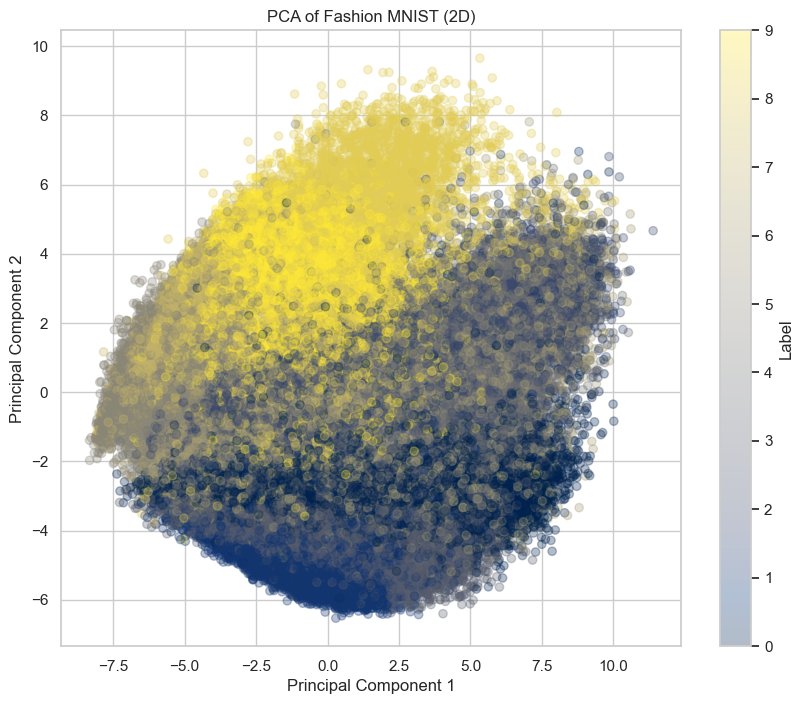

In [364]:
# PCA로 축소된 데이터를 시각화
plt.figure(figsize=(10, 8))
scatter = plt.scatter(train_images_pca_2[:, 0], train_images_pca_2[:, 1], c=train_labels, cmap='cividis', alpha=0.3)
plt.colorbar(scatter, label='Label')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Fashion MNIST (2D)')
plt.show()

## T-SNE

### 앞서 pca를 통해 50차원으로 줄인 데이터를 t-sne를 통해 시각화 하세요.

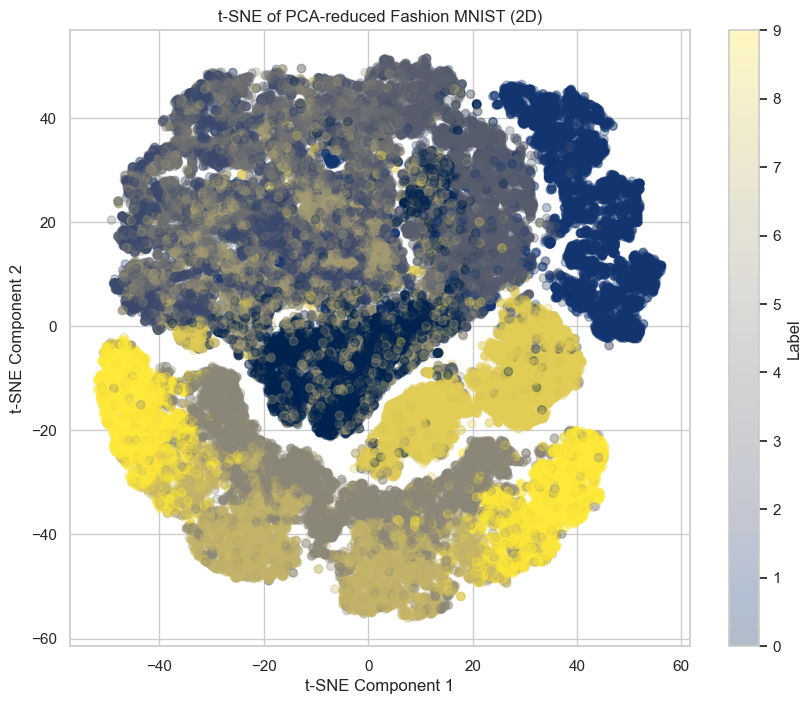

In [365]:
# t-SNE 적용 (2차원으로 축소)
tsne = TSNE(n_components=2, random_state=RandomSeed)
train_images_tsne = tsne.fit_transform(train_images_pca_50)

# t-SNE로 축소된 데이터를 시각화
plt.figure(figsize=(10, 8))
scatter = plt.scatter(train_images_tsne[:, 0], train_images_tsne[:, 1], c=train_labels, cmap='cividis', alpha=0.3)
plt.colorbar(scatter, label='Label')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE of PCA-reduced Fashion MNIST (2D)')
plt.show()

### 앞서 pca를 통해 30차원으로 줄인 데이터를 t-sne를 통해 시각화 하세요.

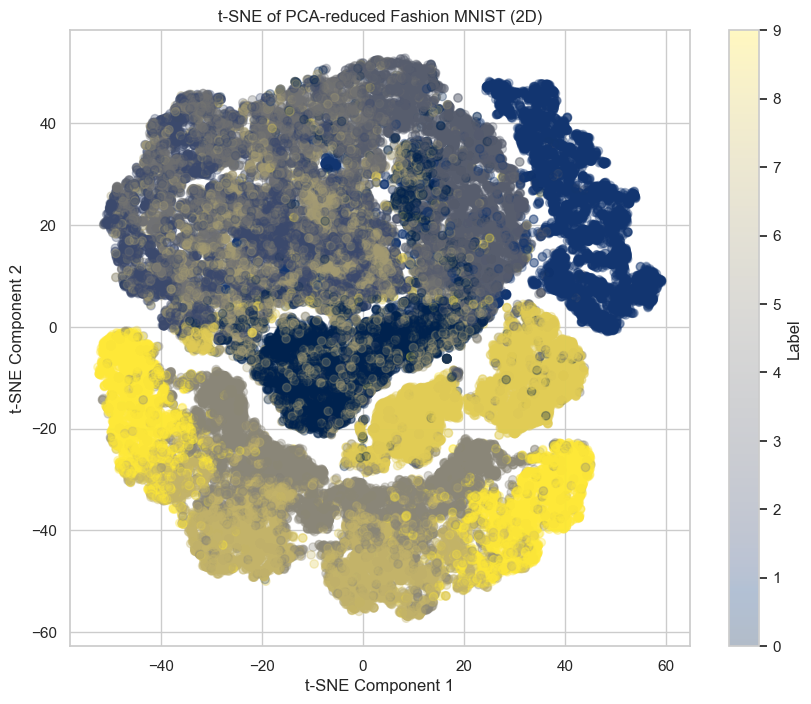

In [366]:
# t-SNE 적용 (2차원으로 축소)
tsne = TSNE(n_components=2, random_state=RandomSeed)
train_images_tsne = tsne.fit_transform(train_images_pca_30)

# t-SNE로 축소된 데이터를 시각화
plt.figure(figsize=(10, 8))
scatter = plt.scatter(train_images_tsne[:, 0], train_images_tsne[:, 1], c=train_labels, cmap='cividis', alpha=0.3)
plt.colorbar(scatter, label='Label')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE of PCA-reduced Fashion MNIST (2D)')
plt.show()

## 군집화

### PCA를 통해 50차원으로 줄인 데이터를 DBSCAN을 이용하여 군집화 하시오.

클러스터 개수: 471
클러스터 레이블: [ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124
 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142
 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160
 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178
 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196
 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214
 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232
 233 234 235 236 237 238 239

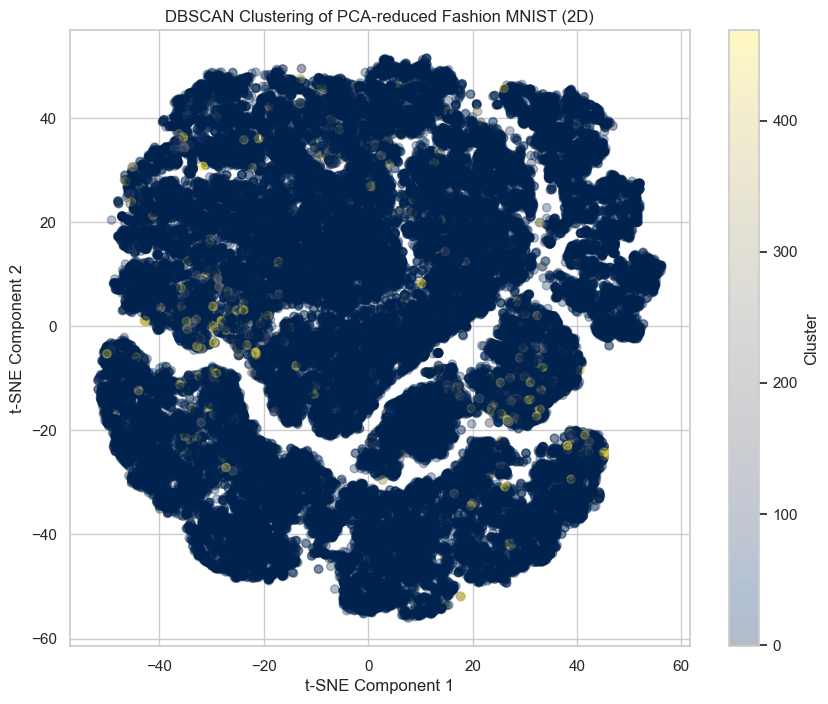

In [367]:
# DBSCAN 군집화 적용
dbscan = DBSCAN(eps=3, min_samples=2)
dbscan_clusters = dbscan.fit_predict(train_images_pca_50)

# 군집화 결과 출력
unique_clusters = np.unique(dbscan_clusters)
print(f"클러스터 개수: {len(unique_clusters)}")
print(f"클러스터 레이블: {unique_clusters}")

# 군집화 결과 시각화 (2차원으로 축소하여 시각화)
tsne = TSNE(n_components=2, random_state=RandomSeed)
train_images_tsne = tsne.fit_transform(train_images_pca_50)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(train_images_tsne[:, 0], train_images_tsne[:, 1], c=dbscan_clusters, cmap='cividis', alpha=0.3)
plt.colorbar(scatter, label='Cluster')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('DBSCAN Clustering of PCA-reduced Fashion MNIST (2D)')
plt.show()

### k-means를 통해 50차원으로 줄인 데이터를 군집화 하시오.(군집의 개수는 10개로 하시오.)

클러스터 개수: 10
클러스터 레이블: [0 1 2 3 4 5 6 7 8 9]


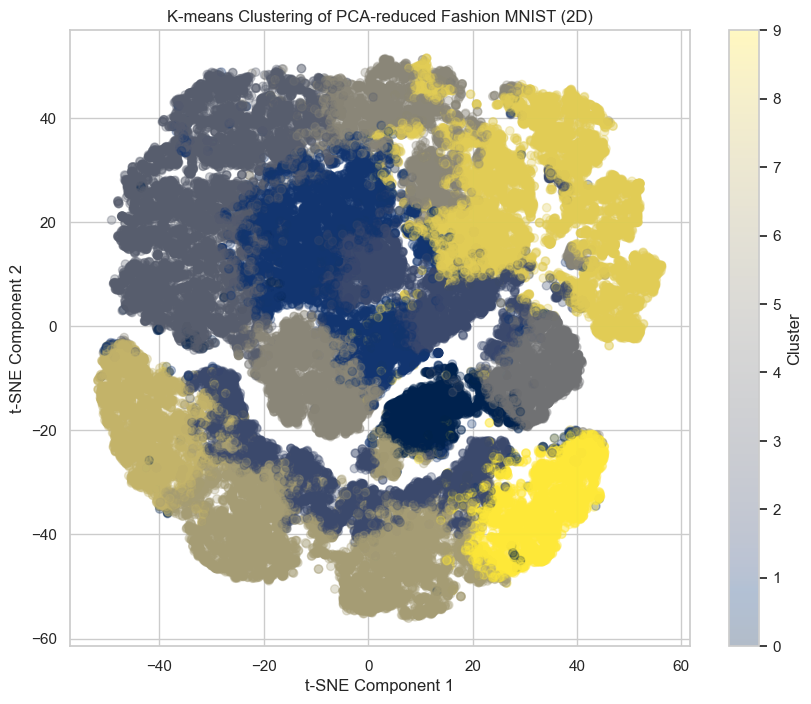

In [368]:
# K-means 군집화 적용 (군집의 개수: 10개)
kmeans = KMeans(n_clusters=10, random_state=RandomSeed)
kmeans_clusters = kmeans.fit_predict(train_images_pca_50)

# 군집화 결과 출력
unique_clusters = np.unique(kmeans_clusters)
print(f"클러스터 개수: {len(unique_clusters)}")
print(f"클러스터 레이블: {unique_clusters}")

# 군집화 결과 시각화 (2차원으로 축소하여 시각화)
tsne = TSNE(n_components=2, random_state=RandomSeed)
train_images_tsne = tsne.fit_transform(train_images_pca_50)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(train_images_tsne[:, 0], train_images_tsne[:, 1], c=kmeans_clusters, cmap='cividis', alpha=0.3)
plt.colorbar(scatter, label='Cluster')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('K-means Clustering of PCA-reduced Fashion MNIST (2D)')
plt.show()

### 엘보우 메소드를 이용하여 k-means에서 가장 적절한 군집의 개수를 구하시오.

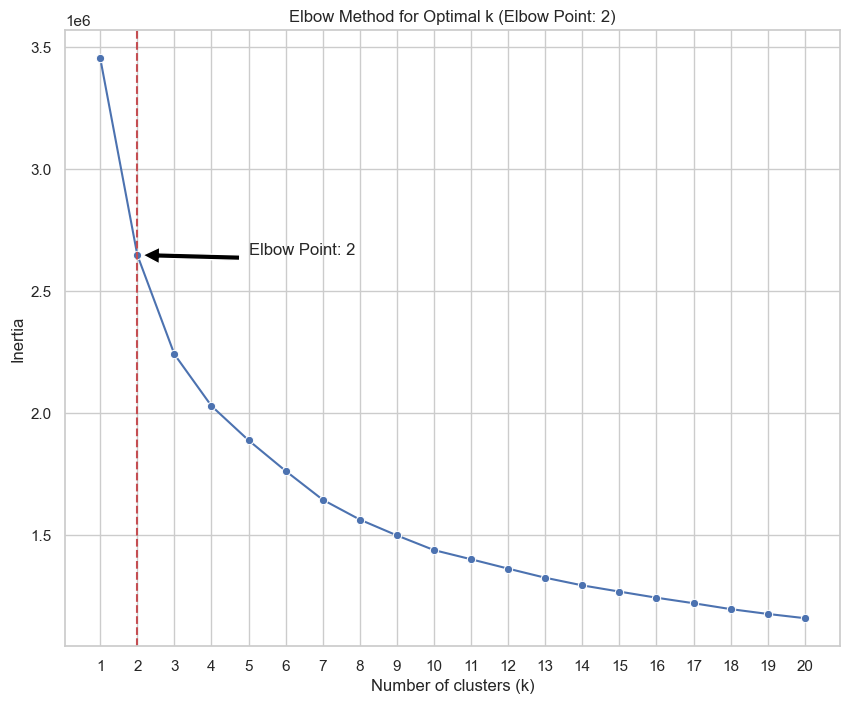

In [369]:
# 엘보우 메소드 적용
inertia = []
K = range(1, 21)  # 1부터 20까지의 군집 개수에 대해 K-means 실행

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=RandomSeed)
    kmeans.fit(train_images_pca_50)
    inertia.append(kmeans.inertia_)

# 엘보우 지점 찾기
def find_elbow_point(inertia):
    # 기울기 계산
    gradients = np.diff(inertia)
    # 기울기 변화 계산
    gradient_changes = np.diff(gradients)
    # 기울기 변화가 가장 큰 지점 찾기
    elbow_point = np.argmax(gradient_changes) + 2  # +2는 인덱스 보정
    return elbow_point

elbow_point = find_elbow_point(inertia)

# 엘보우 메소드 결과 시각화
plt.figure(figsize=(10, 8))
sns.lineplot(x=K, y=inertia, marker='o')
plt.axvline(x=elbow_point, color='r', linestyle='--')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.xticks(K)  # x축 눈금을 정수로 설정
plt.title(f'Elbow Method for Optimal k (Elbow Point: {elbow_point})')

# 엘보우 지점에 화살표 추가
plt.annotate(f'Elbow Point: {elbow_point}', xy=(elbow_point, inertia[elbow_point-1]), 
             xytext=(elbow_point+3, inertia[elbow_point-1]+200),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

### k-means 최적의 군집 개수로 다시 군집화 하여 시각화 하시오.

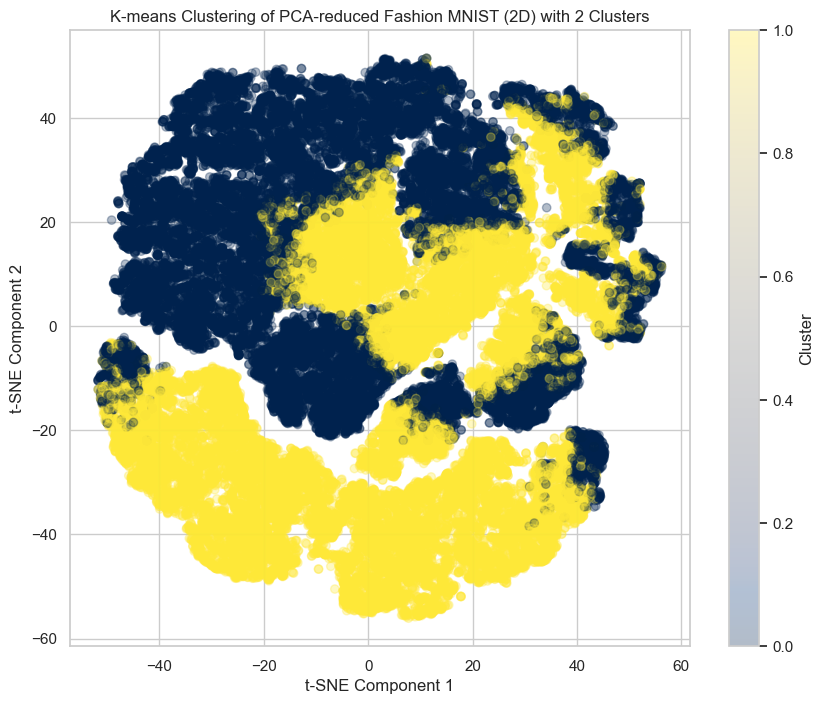

In [370]:
# 최적의 군집 개수 선택 (엘보우 포인트에서 결정)
optimal_k = elbow_point

# K-means 군집화 적용 (최적의 군집 개수)
kmeans = KMeans(n_clusters=optimal_k, random_state=RandomSeed)
kmeans_clusters = kmeans.fit_predict(train_images_pca_50)

# 군집화 결과 시각화 (2차원으로 축소하여 시각화)
tsne = TSNE(n_components=2, random_state=RandomSeed)
train_images_tsne = tsne.fit_transform(train_images_pca_50)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(train_images_tsne[:, 0], train_images_tsne[:, 1], c=kmeans_clusters, cmap='cividis', alpha=0.3)
plt.colorbar(scatter, label='Cluster')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title(f'K-means Clustering of PCA-reduced Fashion MNIST (2D) with {optimal_k} Clusters')
plt.show()

### 다른 추가적인 군집화 기법을 2가지 이상 사용하여 pca 50 데이터를 시각화 하시오.

### Gaussian Mixture Model

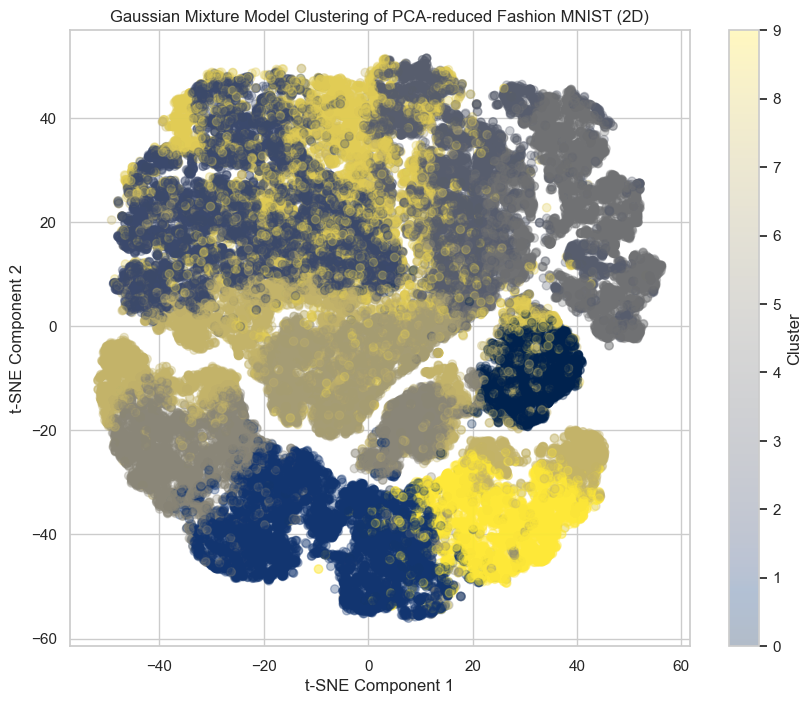

In [ ]:
from sklearn.mixture import GaussianMixture

# Gaussian Mixture Model 적용
gmm = GaussianMixture(n_components=10, random_state=RandomSeed)
gmm_clusters = gmm.fit_predict(train_images_pca_50)

# t-SNE 적용 (2차원으로 축소하여 시각화)
tsne = TSNE(n_components=2, random_state=RandomSeed)
train_images_tsne_gmm = tsne.fit_transform(train_images_pca_50)

# Gaussian Mixture Model 결과 시각화
plt.figure(figsize=(10, 8))
scatter = plt.scatter(train_images_tsne_gmm[:, 0], train_images_tsne_gmm[:, 1], c=gmm_clusters, cmap='cividis', alpha=0.3)
plt.colorbar(scatter, label='Cluster')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('Gaussian Mixture Model Clustering of PCA-reduced Fashion MNIST (2D)')
plt.show()

### Agglomerative Clustering

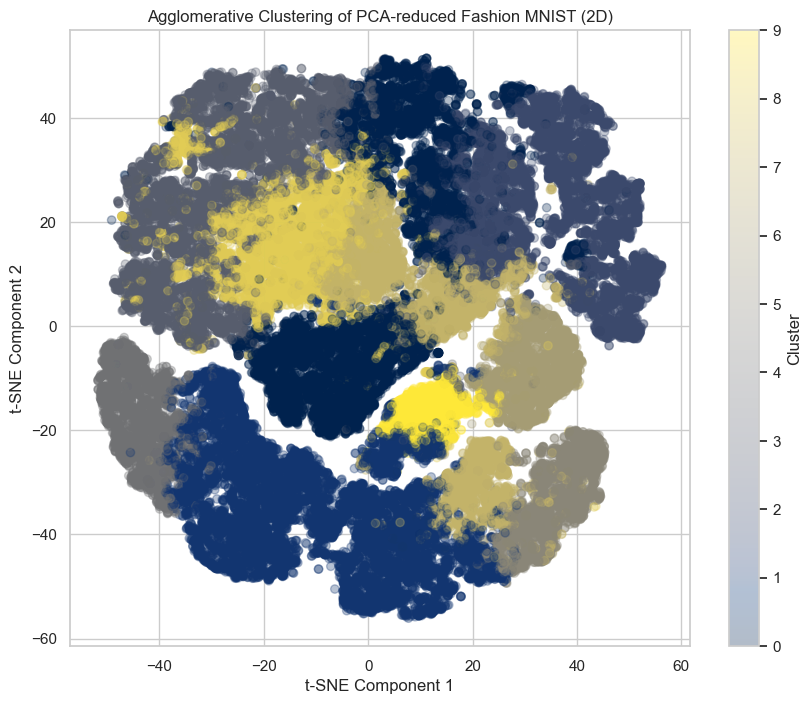

In [ ]:
from sklearn.cluster import AgglomerativeClustering

# Agglomerative Clustering 적용
agg_clustering = AgglomerativeClustering(n_clusters=10) # random_state 옵션 없음
agg_clusters = agg_clustering.fit_predict(train_images_pca_50)

# t-SNE 적용 (2차원으로 축소하여 시각화)
train_images_tsne_agg = tsne.fit_transform(train_images_pca_50)

# Agglomerative Clustering 결과 시각화
plt.figure(figsize=(10, 8))
scatter = plt.scatter(train_images_tsne_agg[:, 0], train_images_tsne_agg[:, 1], c=agg_clusters, cmap='cividis', alpha=0.3)
plt.colorbar(scatter, label='Cluster')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('Agglomerative Clustering of PCA-reduced Fashion MNIST (2D)')
plt.show()

## 군집화 결과 비교

### 앞선 모든 군집화 모델의 결과를 실루엣 점수(Silhouette score)를 이용하여 성능을 비교하시오.

In [373]:
from sklearn.metrics import silhouette_score

# 실루엣 점수 계산
kmeans_silhouette = silhouette_score(train_images_pca_50, kmeans_clusters)
agg_silhouette = silhouette_score(train_images_pca_50, agg_clusters)
gmm_silhouette = silhouette_score(train_images_pca_50, gmm_clusters)
dbscan_silhouette = silhouette_score(train_images_pca_50, dbscan_clusters)

print(f"K-means 실루엣 점수: {kmeans_silhouette}")
print(f"Agglomerative Clustering 실루엣 점수: {agg_silhouette}")
print(f"Gaussian Mixture Model 실루엣 점수: {gmm_silhouette}")
print(f"DBSCAN 실루엣 점수: {dbscan_silhouette}")

K-means 실루엣 점수: 0.2144078193397589
Agglomerative Clustering 실루엣 점수: 0.13060508733092005
Gaussian Mixture Model 실루엣 점수: 0.07103596008668732
DBSCAN 실루엣 점수: -0.4989887357526859


### 실루엣 점수를 통해 군집화 모델의 성능에 대한 간단한 해석을 적으세요.

실루엣 점수는 군집화의 품질을 평가하는 지표로, 값이 클수록 군집화가 잘 된 것을 의미합니다.  
실루엣 점수는 -1에서 1 사이의 값을 가지며, 1에 가까울수록 군집이 잘 분리되고,  
-1에 가까울수록 군집이 겹쳐져 있음을 나타냅니다.

- **K-means 실루엣 점수: 0.2144078193397589**
  - K-means 군집화는 비교적 양호한 성능을 보였습니다.  
  실루엣 점수가 0.2를 넘는 것은 군집이 어느 정도 잘 분리되었음을 의미합니다.

- **Agglomerative Clustering 실루엣 점수: 0.13060508733092005**
  - Agglomerative Clustering의 실루엣 점수는 K-means보다 낮지만,  
  여전히 양호한 성능을 보입니다. 군집이 어느 정도 분리되었음을 나타냅니다.

- **Gaussian Mixture Model 실루엣 점수: 0.07103596008668732**
  - Gaussian Mixture Model의 실루엣 점수는 다소 낮은 편입니다.  
  이는 군집이 잘 분리되지 않았음을 의미할 수 있습니다.

- **DBSCAN 실루엣 점수: -0.4989887357526859**
  - DBSCAN의 실루엣 점수는 음수로, 군집이 잘 분리되지 않았음을 나타냅니다.  
  이는 DBSCAN이 데이터의 구조를 잘 반영하지 못했음을 의미할 수 있습니다.

결론적으로, K-means 군집화가 가장 높은 실루엣 점수를 기록하여 가장 우수한 성능을 보였으며,  
DBSCAN은 가장 낮은 실루엣 점수를 기록하여 성능이 좋지 않았음을 알 수 있습니다.  

.